# NEURAL NETWORK with K-MEANS for MNIST

#### Import

In [17]:
import sys
import time
import pickle
import gzip
from random import randint
from scipy import misc
from scipy import special
import numpy as np
import datetime as dt
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import json

#### Timing function

In [2]:
def timing(f):
    def wrap(*args):
        time1 = time.time()
        ret = f(*args)
        time2 = time.time()
        print('%s function took %0.2f ms' % (f.__name__, (time2-time1)*1000.0))
        return ret
    return wrap

#### Initial Settings

In [3]:
DATA_PATH = 'data/mnist/'

IMAGES_TRAIN = 'data_training'
IMAGES_TEST = 'data_testing'

RANDOM_SEED = 42
N_CLASSES = 10
N_FEATURES = 28 * 28

In [4]:
data_training = DATA_PATH+IMAGES_TRAIN
data_testing = DATA_PATH+IMAGES_TEST
ft = gzip.open(data_training, 'rb')
TRAINING = pickle.load(ft)
ft.close()
ft = gzip.open(data_testing, 'rb')
TESTING = pickle.load(ft)
ft.close()

## Neural Network

In [5]:
class Neural_Network:

    def __init__(self, neurons=100, epochs=0, batchsize=20):
        self.input_size = N_FEATURES
        self.output_size = N_CLASSES
        self.neurons = neurons
        self.batchsize = batchsize
        
        # Decide training method (epochs or covergence)
        self.epochs = epochs
        if epochs == 0:
            self.best = 0.
            self.same = 0

        # Standardize random weights
        np.random.seed(RANDOM_SEED)
        hidden_layer = np.random.rand(self.neurons, self.input_size + 1) / self.neurons
        output_layer = np.random.rand(self.output_size, self.neurons + 1) / self.output_size
        self.layers = [hidden_layer, output_layer]
        self.iteration = 0

    def train(self, training):
        
        # Start prints 
        self.start_time = dt.datetime.now()
        print('-- Training Session Start (%s) --' % (self.start_time))
        typeTrainingPrint = "Epochs: "+str(self.epochs)
        if self.epochs == 0:
            typeTrainingPrint = "Until 5 iterations w/o improvements";
        print('\nNeurons: %d\nBatch Size: %d\n%s\n' % (self.neurons,self.batchsize,typeTrainingPrint))
        
        # Divide training batches
        inputs = training[0][0:self.batchsize]
        targets = np.zeros((self.batchsize, 10))
        for i in range(self.batchsize):
            targets[i, training[1][i]] = 1

        # Performs iterations
        while (self.epochs == 0 and self.same < 10) or (self.iteration < self.epochs):
            for input_vector, target_vector in zip(inputs, targets):
                self.backpropagate(input_vector, target_vector)
                
            # ETA
            diff = dt.datetime.now() - self.start_time
            eta = divmod(diff.days * 86400 + diff.seconds, 60)
            if eta[0] != 0:
                etaPrint = str(eta[0])+"m"
            else:
                etaPrint = ""
            etaPrint += str(eta[1])+"s"
            
            # Accuracy
            accu = self.accu(TESTING)
            self.iteration += 1
            
            # Messages
            if (self.iteration == 1 or self.iteration % 10 == 0 or self.iteration == self.epochs):
                self.print_message_iter(self.iteration,accu,etaPrint)
            
            # Control coverange
            if self.epochs == 0:
                if accu[0] > self.best:
                    self.same = 0
                    self.best = accu[0]
                else:
                    self.same += 1
                
        # Print last epoch in coverange situation
        if self.iteration % 10 != 0:
            self.print_message_iter(self.iteration,accu,etaPrint)

        # Final message
        print('\n-- Training Session End (%s) --' % (dt.datetime.now()))

    def feed_forward(self, input_vector):
        """Takes a network (Matrix list) and returns the outputs of both
         layers by propagating the entry"""
        outputs = []
        for layer in self.layers:
            input_with_bias = np.append(input_vector, 1)   # Ajout constante
            output = np.inner(layer, input_with_bias)
            output = special.expit(output)
            outputs.append(output)
            # The output is the input of the next layer
            input_vector = output
        return outputs

    def backpropagate(self, input_vector, target):
        """Reduce error for one input vector:
        Calculating the partial derivatives for each coeff then subtracts"""
        c = 1./(self.iteration + 10)  # Learning coefficient
        hidden_outputs, outputs = self.feed_forward(input_vector)

        # Calculation of partial derivatives for the output layer and subtraction
        output_deltas = outputs * (1 - outputs) * (outputs - target)
        self.layers[-1] -= c*np.outer(output_deltas, np.append(hidden_outputs, 1))

        # Calculation of partial derivatives for the hidden layer and subtraction
        hidden_deltas = hidden_outputs * (1 - hidden_outputs) * \
            np.dot(np.delete(self.layers[-1], 200, 1).T, output_deltas)
        self.layers[0] -= c*np.outer(hidden_deltas, np.append(input_vector, 1))

    def predict(self, input_vector):
        return self.feed_forward(input_vector)[-1]

    def predict_one(self, input_vector):
        return np.argmax(self.feed_forward(input_vector)[-1])

    def load(self, file_name):
        f = open(file_name, 'rb')
        self.layers = pickle.load(f, encoding='latin1')
        f.close()

    def accu(self, testing):
        """The lowest precision digit and total"""
        res = np.zeros((10, 2))
        for k in range(len(testing[1])):
            if self.predict_one(testing[0][k]) == testing[1][k]:
                res[testing[1][k]] += 1
            else:
                res[testing[1][k]][1] += 1
        total = np.sum(res, axis=0)
        each = [res[k][0]/res[k][1] for k in range(len(res))]
        min_c = sorted(range(len(each)), key=lambda k: each[k])[0]
        return np.round([each[min_c]*100, total[0]/total[1]*100, min_c], 2)
    
    def print_message_iter(self,iteration,accu,eta):
        len_eta = len(eta)
        space_fill = 6 - len_eta
        eta = "("+eta+")"
        for _ in range(space_fill):
            eta += " "
        message = 'Epoch '+str(self.iteration).zfill(3) + " "+eta+" "
        message += 'Precision G:'+str(accu[1]).zfill(4)+'%\tMin:'+ str(accu[0]).zfill(4)+ '% ('+str(int(accu[2]))+')'
        print(message)
        
    def getWeights(self):
        return self.layers

In [81]:
nn = Neural_Network(neurons=300,epochs=0,batchsize=5000)
nn.train(TRAINING)

-- Training Session Start (2018-07-03 16:34:58.840891) --

Neurons: 300
Batch Size: 5000
Until 5 iterations w/o improvements

Epoch 001 (4s)     Precision G:75.71%	Min:16.63% (8)
Epoch 010 (52s)    Precision G:90.93%	Min:80.99% (3)
Epoch 020 (1m43s)  Precision G:92.0%	Min:87.33% (3)
Epoch 030 (2m33s)  Precision G:92.51%	Min:89.0% (9)
Epoch 040 (3m24s)  Precision G:92.65%	Min:89.4% (9)
Epoch 050 (4m15s)  Precision G:92.76%	Min:89.59% (9)
Epoch 060 (5m6s)   Precision G:92.91%	Min:89.79% (9)
Epoch 069 (5m57s)  Precision G:92.95%	Min:89.69% (9)

-- Training Session End (2018-07-03 16:40:56.786771) --


## K-MEANS

#### Find nearest centroid given a value

In [7]:
def nearest_centroid_index(centers,value):
    centers = np.asarray(centers)
    idx = (np.abs(centers - value)).argmin()
    return idx

def nearest_centroid(centers,value):
    centers = np.asarray(centers)
    idx = (np.abs(centers - value)).argmin()
    return centers[idx]

#### Building clusters with pre trained weights

In [84]:
nn_weights = nn.getWeights()

def reshape_weights_for_kmeans(weights):
    return np.append(np.hstack(nn_weights[0]),np.hstack(nn_weights[1])).reshape(-1,1)

def build_clusters(cluster,weights):
    kmeans = KMeans(n_clusters=cluster,random_state=RANDOM_SEED)
    kmeans.fit(reshape_weights_for_kmeans(weights))
    return kmeans

build_clusters(25,nn_weights)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=25, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

#### Redifine weights matrix for pre train

In [10]:
def redefine_weights(centers,weights):
        arr_ret = np.empty_like(weights)
        for k,w in enumerate(weights):
            arr_int = np.empty_like(w)
            for i, row in enumerate(w):
                for j, col in enumerate(row):
                    arr_int[i,j] = nearest_centroid(centers,w[i,j])
            arr_ret[k] = arr_int
        return arr_ret

#### Mean of distance between elements in centroid

In [12]:
def mean_distance(weights,centroids):
    tot = 0.
    for k,wei in enumerate(weights):
        for i, row in enumerate(wei):
            for j, col in enumerate(row):
                weight = wei[i,j]
                centroid = nearest_centroid(centroids,weight)[0]
                tot += np.sqrt((weight - centroid)**2)
    return tot / ((k+1)*(i+1)*(j+1))

#### Mean with different clusters number

In [13]:
def find_clusters_number(values,n_from,n_to,n_jump):
    start_time = dt.datetime.now()
    RANDOM_SEED = 42
    result = {}
    for i in range(n_from,n_to+1,n_jump):
        kmeans = KMeans(n_clusters=i,random_state=RANDOM_SEED)
        kmeans.fit(reshape_weights_for_kmeans(values))
        mean = mean_distance(values,kmeans.cluster_centers_)
        result[i] = mean
        print("Mean for %s clusters %f (%s) " % (str(i).zfill(3),mean,eta_from_start(start_time)))
    return result

def eta_from_start(start_time):
    diff = dt.datetime.now() - start_time
    eta = divmod(diff.days * 86400 + diff.seconds, 60)
    return str(eta[0])+"m"+str(eta[1])+"s"
        
means_cluster_1_10 = find_clusters_number(nn_weights,1,10,1)

Mean for 001 clusters 1.333229 (0m2s) 
Mean for 002 clusters 1.229275 (0m4s) 
Mean for 003 clusters 0.855299 (0m7s) 
Mean for 004 clusters 0.810955 (0m12s) 
Mean for 005 clusters 0.696510 (0m18s) 
Mean for 006 clusters 0.608810 (0m24s) 
Mean for 007 clusters 0.514373 (0m31s) 
Mean for 008 clusters 0.458859 (0m38s) 
Mean for 009 clusters 0.423324 (0m47s) 
Mean for 010 clusters 0.392233 (1m0s) 


#### Reading from JSON

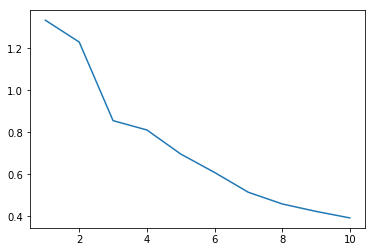

In [85]:
def get_data_from_json(file):
    with open(file) as f:
        return json.load(f)
    
def get_list_values_from_json(data,field,variable):
    return [element[field] for element in data[variable]]

data = get_data_from_json('log/Log_Cluster_Setting_Mean.json')
x = get_list_values_from_json(data,"cluster","cluster_mean")
y = get_list_values_from_json(data,"mean","cluster_mean")

plt.plot(x[:10],y[:10])
plt.show()

## Neural Network with Pre-Trained Weights (K-Means)

In [56]:
class Neural_Network_KMeans_PreTrained:

    def __init__(self, neurons=100, epochs=0, batchsize=1000, cluster=10, pre_weights=None, verbose=True):
        
        start_setting_time = dt.datetime.now()
        
        self.input_size = N_FEATURES
        self.output_size = N_CLASSES
        self.neurons = neurons
        self.batchsize = batchsize
        self.verbose = verbose
        self.cluster = cluster
        self.iteration = 0
        
        # Decide training method (epochs or convergence)
        self.epochs = epochs
        if epochs == 0:
            self.best = 0.
            self.same = 0
            
        # Initialize clusters for pre-trained weights
        if pre_weights != None and cluster != 0:
            self.dict_centroid = {}
            self.k_means = build_clusters(cluster,pre_weights)
            for i,c in enumerate(self.k_means.cluster_centers_):
                self.dict_centroid[i] = c[0]
            self.layers = redefine_weights(self.k_means.cluster_centers_,pre_weights)
        else:
            np.random.seed(RANDOM_SEED)
            hidden_layer = np.random.rand(self.neurons, self.input_size + 1) / self.neurons
            output_layer = np.random.rand(self.output_size, self.neurons + 1) / self.output_size
            self.layers = [hidden_layer, output_layer]
            
        end_setting_time = dt.datetime.now() - start_setting_time
        eta = divmod(end_setting_time.days * 86400 + end_setting_time.seconds, 60)
        self.eta_print_setting = str(eta[0])+"m"+str(eta[1])+"s"
        self.space_weights = sys.getsizeof(np.append(np.hstack(self.layers[0]),np.hstack(self.layers[1])))
        if self.verbose:
            print("--- Setting Time: %s ---" % self.eta_print_setting)
            print("--- Space in Memory: %s bytes ---\n" % self.space_weights)
 

    def train(self, training):
        
        # Start prints 
        self.start_time = dt.datetime.now()
        if self.verbose:
            print('-- Training Session Start (%s) --' % (self.start_time))
            typeTrainingPrint = "Epochs: "+str(self.epochs)
            if self.epochs == 0:
                typeTrainingPrint = "Until 5 iterations w/o improvements";
            print('\nNeurons: %d\nBatch Size: %d\n%s\n' % (self.neurons,self.batchsize,typeTrainingPrint))
        
        # Divide training batches
        inputs = training[0][0:self.batchsize]
        targets = np.zeros((self.batchsize, 10))
        for i in range(self.batchsize):
            targets[i, training[1][i]] = 1

        # Performs iterations
        while (self.epochs == 0 and self.same < 10) or (self.iteration < self.epochs):
            for input_vector, target_vector in zip(inputs, targets):
                self.backpropagate(input_vector, target_vector)
                
            # ETA
            diff = dt.datetime.now() - self.start_time
            eta = divmod(diff.days * 86400 + diff.seconds, 60)
            if eta[0] != 0:
                etaPrint = str(eta[0])+"m"
            else:
                etaPrint = ""
            etaPrint += str(eta[1])+"s"
            
            # Accuracy
            accu = self.accu(TESTING)
            self.iteration += 1
            
            # Messages
            if self.verbose and (self.iteration == 1 or self.iteration % 10 == 0 or self.iteration == self.epochs):
                self.print_message_iter(self.iteration,accu,etaPrint)
            
            # Control coverange
            if self.epochs == 0:
                if accu[0] > self.best:
                    self.same = 0
                    self.best = accu[0]
                else:
                    self.same += 1
                
        # Print last epoch in convergence situation
        if self.iteration % 10 != 0 and self.verbose:
            self.print_message_iter(self.iteration,accu,etaPrint)

        # Final message
        if self.verbose:
            print('\n-- Training Session End (%s) --' % (dt.datetime.now()))
        else:
            setting_time = self.minsec2sec(self.eta_print_setting)
            train_time = self.minsec2sec(etaPrint)
            print("{")
            print("\"neuron\" : %d,\n\"epoch\" : %d,\n\"batch\" : %d,\n\"cluster\" : %d,\n\"setting_time\" : %d,\n\"train_time\" : %d,\n\"space\" : %d,\n\"accuracy\" : %.4f,\n\"minimun\" : %.4f" % (self.neurons,self.iteration,self.batchsize,self.cluster,setting_time,train_time,self.space_weights,accu[1]/100,accu[0]/100))
            print("}")

    def feed_forward(self, input_vector):
        """Takes a network (Matrix list) and returns the outputs of both
         layers by propagating the entry"""
        outputs = []
        for layer in self.layers:
            input_with_bias = np.append(input_vector, 1)   # Ajout constante
            output = np.inner(layer, input_with_bias)
            output = special.expit(output)
            outputs.append(output)
            # The output is the input of the next layer
            input_vector = output
        return outputs

    def backpropagate(self, input_vector, target):
        """Reduce error for one input vector:
        Calculating the partial derivatives for each coeff then subtracts"""
        c = 1./(self.iteration + 10)  # Learning coefficient
        hidden_outputs, outputs = self.feed_forward(input_vector)

        # Calculation of partial derivatives for the output layer and subtraction
        output_deltas = outputs * (1 - outputs) * (outputs - target)
        self.layers[-1] -= c*np.outer(output_deltas, np.append(hidden_outputs, 1))

        # Calculation of partial derivatives for the hidden layer and subtraction
        hidden_deltas = hidden_outputs * (1 - hidden_outputs) * \
            np.dot(np.delete(self.layers[-1], 200, 1).T, output_deltas)
        self.layers[0] -= c*np.outer(hidden_deltas, np.append(input_vector, 1))

    def predict(self, input_vector):
        return self.feed_forward(input_vector)[-1]

    def predict_one(self, input_vector):
        return np.argmax(self.feed_forward(input_vector)[-1])

    def load(self, file_name):
        f = open(file_name, 'rb')
        self.layers = pickle.load(f, encoding='latin1')
        f.close()

    def accu(self, testing):
        """The lowest precision digit and total"""
        res = np.zeros((10, 2))
        for k in range(len(testing[1])):
            if self.predict_one(testing[0][k]) == testing[1][k]:
                res[testing[1][k]] += 1
            else:
                res[testing[1][k]][1] += 1
        total = np.sum(res, axis=0)
        each = [res[k][0]/res[k][1] for k in range(len(res))]
        min_c = sorted(range(len(each)), key=lambda k: each[k])[0]
        return np.round([each[min_c]*100, total[0]/total[1]*100, min_c], 2)
    
    def print_message_iter(self,iteration,accu,eta):
        len_eta = len(eta)
        space_fill = 6 - len_eta
        eta = "("+eta+")"
        for _ in range(space_fill):
            eta += " "
        message = 'Epoch '+str(self.iteration).zfill(3) + " "+eta+" "
        message += 'Precision G:'+str(accu[1]).zfill(4)+'%\tMin:'+ str(accu[0]).zfill(4)+ '% ('+str(int(accu[2]))+')'
        print(message)
        
    def getWeights(self):
        return self.layers
    
    def minsec2sec(self,time):
        if 'm' in time:
            splitted = time.split('m')
            return int(splitted[0]) * 60 + int(splitted[1][:-1])
        else:
            return int(time[:-1])
            

In [87]:
nn_km_pt = Neural_Network_KMeans_PreTrained(300,0,5000,3,nn_weights,verbose=True)
nn_km_pt.train(TRAINING)

--- Setting Time: 0m2s ---
--- Space in Memory: 1908176 bytes ---

-- Training Session Start (2018-07-03 16:42:05.269649) --

Neurons: 300
Batch Size: 5000
Until 5 iterations w/o improvements

Epoch 001 (4s)     Precision G:91.69%	Min:86.04% (3)
Epoch 010 (52s)    Precision G:92.76%	Min:88.01% (9)
Epoch 020 (1m44s)  Precision G:93.12%	Min:88.4% (9)
Epoch 024 (2m4s)   Precision G:93.16%	Min:88.31% (9)

-- Training Session End (2018-07-03 16:44:10.681219) --


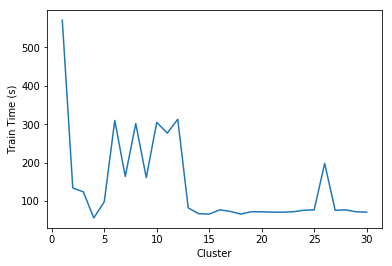

In [77]:
def get_data_from_json(file):
    with open(file) as f:
        return json.load(f)
    
def get_list_values_from_json(data,field,variable):
    return [element[field] for element in data[variable]]

data = get_data_from_json('Log_KMeans_PreTrained.json')
x = get_list_values_from_json(data,"cluster","nn_kmeans_pre_trained")
y = get_list_values_from_json(data,"train_time","nn_kmeans_pre_trained")

plt.plot(x,y)
plt.xlabel('Cluster')
plt.ylabel('Train Time (s)')
plt.show()